# Script to explore finding and fitting transits with LightKurve and other packages
### Last modified 6/25/21 by Anna Zuckerman


In [478]:
!pip install lightkurve

Defaulting to user installation because normal site-packages is not writeable


In [522]:
pip install --pre --upgrade astroquery

Defaulting to user installation because normal site-packages is not writeable
Requirement already up-to-date: astroquery in /mnt_home/azuckerman/.local/lib/python3.7/site-packages (0.4.3)
Note: you may need to restart the kernel to use updated packages.


In [1]:
# import packages
import lightkurve as lk
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from astroquery.nasa_exoplanet_archive import NasaExoplanetArchive
import numpy as np

In [67]:
# search for and download all lightcurves
obs_type = 'kepler'
planet_name = 'kepler-69 b'
star_name = 'kepler-69'
search_result = lk.search_lightcurve(star_name, author=obs_type, cadence='long')
lc_collection = search_result.download_all()

# stitch together, flatten, and normalize all observations
lc = lc_collection.stitch().flatten(window_length=901).remove_outliers()

In [73]:
# get cadence information
cadence_type = lc.meta['OBSMODE'] 
if obs_type == 'Kepler' or obs_type == 'kepler':
    if cadence_type == 'long cadence':
        cadence = 1764 # sec
    if cadence_type == 'short cadence':
        cadence = 58.85 # sec   
        
if obs_type == 'TESS':
    print('TESS CADENCE INFO NOT YET IMPLEMENTED!')
    

1764

Text(0.5, 1.0, 'Kepler-69 b')

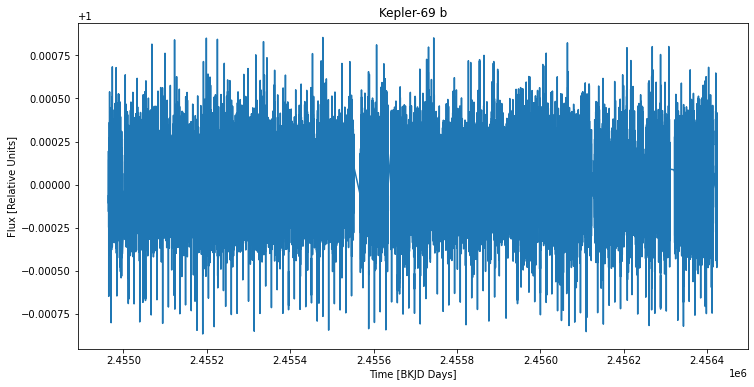

In [17]:
# plot lightcurve
flux = lc.flux.value           # Flux [relative units]
time = lc.time.value + 2454833 # Time  [BKJD days]
err = lc.flux_err.value        # Uncertainty in flux
plt.figure(figsize = [12,6])
plt.plot(time, flux)
plt.xlabel('Time [BKJD Days]')
plt.ylabel('Flux [Relative Units]')
plt.title('Kepler-69 b')


In [ ]:
# Known properties of the transit from NASA Exoplanet Archive
# [NOTE: NEED TO DO THIS PROGRAMATICALLY!]

#period = 13.722                               # Days
#t0 = 2454970.84                               # Days
#R_p = 2.28                                    # Earth radii
#R_star = 1.04                                 # Ro [NOTE: this is an average of exoplanet archive values]
#R_p_star = (R_p * 6378.14)/(R_star * 696340)  # Rp/R* 
#a = 0.10                                      # AU
#inc = 89.4                                    # Inclination [deg]
#ecc = 0                                       # Ecentricity (NOTE: Barclay et al. 2013 says 0.16 +0.17/-0.001)
#w = #???                                     # [NOT LISTED IN NASA TABLE]
#u = #???                                     # [NOT LISTED IN NASA TABLE]
#limb_darkening_model = 'quadratic'
#impact_parameter = 0.254                      # NOTE: This is mode but varies widely in NASA Exoplanet Archive table

In [76]:
# get planet properties from NASA Exoplanet Archive <-- is this table deprecated??

planet = NasaExoplanetArchive.query_object(planet_name)
period = np.nanmedian(planet['pl_orbper']).value # Planet period [Days]
t0 = np.nanmedian(planet['pl_tranmid']).value # Transit midpoint (??) [Days]
R_p = np.nanmedian(planet['pl_rade']).value * 0.0091577 # Planet radius [Ro]
R_star = np.nanmedian(planet['st_rad']).value  # Star radius [Ro]
impact_parameter = np.nanmedian(planet['pl_imppar']) # impact parameter 
RpRs = R_p/R_star # Planet star radius ratio = sqrt(transit depth)
expected_points_per_window = np.floor((period * 24 * 60 * 60 * 0.5) / cadence)

print('period: ' + str(period))
print('t0: ' + str(t0))
print('RpRs: ' + str(RpRs))
print('impact parameter: ' + str(impact_parameter))
print('expected number points per 1/2 period transit fitting window: ' + str(expected_points_per_window))

period: 13.7223682
t0: 2454970.84083
RpRs: 0.022094768253968253
impact parameter: 0.254
expected number points per 1/2 period transit fitting window: 336.0


/opt/conda/lib/python3.7/site-packages/numpy/lib/function_base.py:3636: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  part.partition(kth)


## Fit transits as Gaussians

In [88]:
# fit guassian to transits using known t0 as guessed location

def fit_gaussian(transit_idx, verbosity):

    # area around expected transit
    low_bound = t0 + period * transit_idx - period/4     # /4 is somewhat arbitrary
    up_bound = t0 + period * transit_idx + period/4
    # all intervals are ~same in time duration, but not in number of steps/pixels
    interval = (low_bound < time)*(time < up_bound)
    time_interval = np.max(time[time < up_bound]) -  np.min(time[time > low_bound])
    length = len(time[interval])
    
    # for checking that datapoints immediatley around transit is not missing
    # becuase the location of the missing data within the transit window mattters
    inner_low_bound = t0 + period * transit_idx - period/8     # /4 is somewhat arbitrary
    inner_up_bound = t0 + period * transit_idx + period/8
    # all intervals are ~same in time duration, but not in number of steps/pixels
    inner_interval = (inner_low_bound < time)*(time < inner_up_bound)
    inner_time_interval = np.max(time[time < inner_up_bound]) -  np.min(time[time > inner_low_bound])
    inner_length = len(time[inner_interval])
    
    if verbosity == 2:
    #    print(low_bound); print(up_bound)
    #    print(np.min(time[time > low_bound])); print(np.max(time[time < up_bound]))
    #    print(time_interval)
    #    plt.plot(time[interval],flux[interval], '.', markersize = 5,label = 'Kepler-69b Data')
         print(length)
    apply_thresholds = 1
    min_points_threshold = expected_points_per_window * 0.90
    if apply_thresholds:
        #if time_interval < period/4: # the last interval won't necessarily contain a full transit and some contain missing data; threshold somewhat arbitrary
        #    print('Could not model transit ' + str(transit_idx) + ' (interval too short, likely due to missing data).')          
        #    return [np.nan, np.nan, np.nan], np.nan, np.nan, np.nan, np.nan
        #if (length < 250) or (inner_length < 150): # these thresholds might be too harsh
        #    print('Could not model transit ' + str(transit_idx) + ' (due to missing data).')          
        #    return [np.nan, np.nan, np.nan], np.nan, np.nan, np.nan, np.nan
        #if (inner_length < 150): # these thresholds might be too harsh
        if (length < min_points_threshold):
            print('Could not model transit ' + str(transit_idx) + ' (due to missing data).')          
            return [np.nan, np.nan, np.nan], np.nan, np.nan, np.nan, np.nan
    
    print('Modelling transit ' + str(transit_idx))

    # fit a guassian to the transit
    def gaussian(x, a, b, c):
        return a*np.exp(-np.power(x - b, 2)/(2*np.power(c, 2)))
    guess_params =[-0.1, t0 + period * transit_idx, 0.1] # somewhat arbitrary, but seems like a < 0 works, b = t0, and 0.01 < c < 10 
    pars, cov = curve_fit(f=gaussian, xdata=time[interval], ydata=flux[(interval)]-1, p0 = guess_params, bounds=(-np.inf, np.inf), maxfev = 80000)
    model_gaussian = pars[0]*np.exp((-(time[interval]-pars[1])**2)/(2*pars[2])**2) + 1
    RMSE = np.sqrt(np.sum((flux[interval] - model_gaussian)**2/length))

    if verbosity == 1:   
        plt.figure(figsize = [12,6])
        plt.plot(time[interval],flux[interval], '.', markersize = 5,label = 'Kepler-69b Data')
        plt.plot(time[interval],model_gaussian, label = 'Guassian fit')
        plt.legend()
        plt.xlabel('Time [BKJD Days]')
        plt.ylabel('Flux [Relative Units]')
        plt.title('Kepler-69 b, transit ' + str(transit_idx))
        print('Gaussian parameters for transit ' + str(transit_idx) +':')
        print('     a = ' + str(np.round(pars[0],4)))
        print('     b = ' + str(np.round(pars[1],3)))
        print('     c = ' + str(np.round(pars[2],4)))
        print('     RMSE = ' + str(np.round(RMSE,4)))
        print()
    return(pars, RMSE, length, inner_length, time_interval)
 
#for i in range(0,106,1):
#    print(i)
#    pars = fit_gaussian(i,0)

num_transits = int(np.floor((time[-1] - t0) / period))
expected_midpoints = np.arange(t0, t0 + (num_transits) * period, period)
midpoints = [] # store midpoints of all transits
depths = [] # store transit depths
lengths = [] # store number of points in each transit interval window
inner_lengths = [] # store number of points in transit window near transit
time_intervals = [] # store time intervals of each transit window
RMSE_arr = [] # store RMSE of the fit to each transit
skipped = [] # record which transit idxs are skipped
for transit_idx in np.linspace(0,num_transits-1,num_transits):
    try: 
        pars, RMSE, length, inner_length, time_interval = fit_gaussian(transit_idx, verbosity = 0)
    except ValueError:
        print('skipped transit' + str(transit_idx))
        pars, RMSE, length, inner_length, time_interval = [np.nan, np.nan, np.nan], np.nan, np.nan, np.nan, np.nan
    depths += [pars[0]]
    midpoints += [pars[1]]
    lengths += [length]
    inner_lengths += [inner_length]
    RMSE_arr += [RMSE]
    time_intervals += [time_interval]
    if np.isnan(pars[0]):
        skipped += [transit_idx]
        
depths = np.array(depths)
midpoints = np.array(midpoints)
mean_transit_depth = np.nanmean(depths)
expected_depth = -RpRs**2
delta_depths = mean_transit_depth - depths
delta_midpoints = expected_midpoints - midpoints  

print()
print(str(len(skipped)) + ' transits skipped out of ' + str(num_transits) + ' total transits.')

Modelling transit 0.0
Modelling transit 1.0
Could not model transit 2.0 (due to missing data).
Could not model transit 3.0 (due to missing data).
Modelling transit 4.0
Modelling transit 5.0
Modelling transit 6.0
Could not model transit 7.0 (due to missing data).
Modelling transit 8.0
Could not model transit 9.0 (due to missing data).
Modelling transit 10.0
Could not model transit 11.0 (due to missing data).
Modelling transit 12.0
Modelling transit 13.0
Modelling transit 14.0
Modelling transit 15.0
Modelling transit 16.0
Modelling transit 17.0
Could not model transit 18.0 (due to missing data).
Could not model transit 19.0 (due to missing data).
Modelling transit 20.0
Modelling transit 21.0
Could not model transit 22.0 (due to missing data).
Modelling transit 23.0
Modelling transit 24.0
Modelling transit 25.0
Modelling transit 26.0
Modelling transit 27.0
Modelling transit 28.0
Could not model transit 29.0 (due to missing data).
Modelling transit 30.0
Modelling transit 31.0
Modelling tra

Text(0, 0.5, 'Midpoint - expected midpoint')

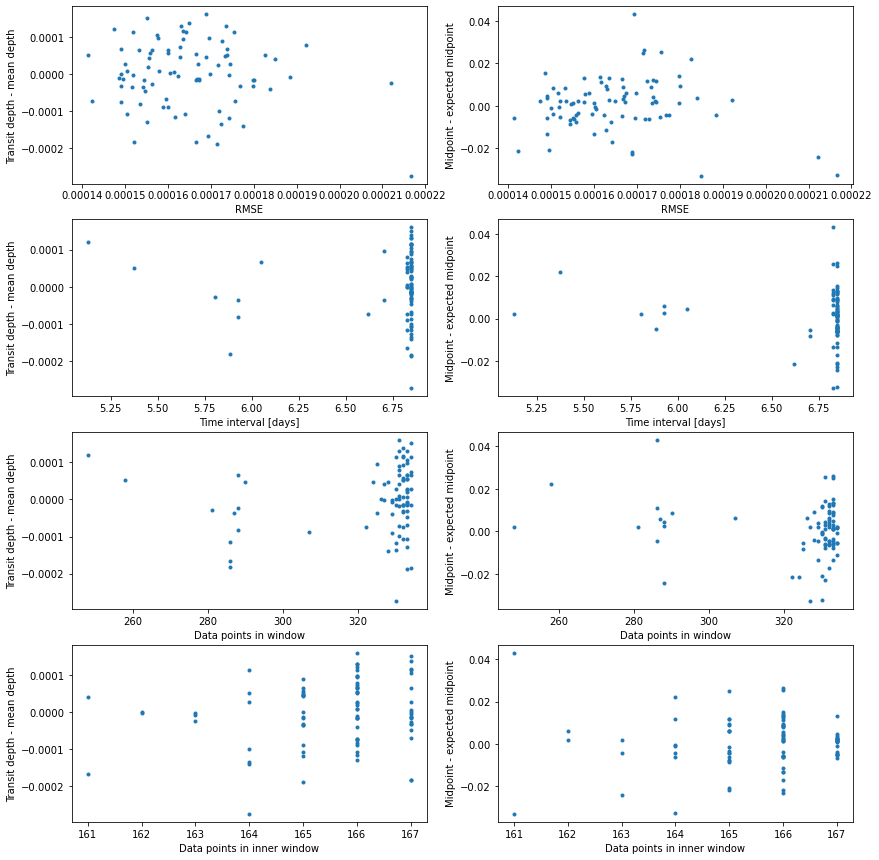

In [31]:
# Determine quality thresholds on goodness of fit and amount of data in each fit

# RMSE threshold
plt.figure(figsize = [14,15])
plt.subplot(421)
plt.plot(RMSE_arr, delta_depths,'.')
#plt.yscale('symlog')
plt.xlabel('RMSE'); plt.ylabel('Transit depth - mean depth')
plt.subplot(422)
plt.plot(RMSE_arr, delta_midpoints,'.')
#plt.yscale('symlog')
plt.xlabel('RMSE'); plt.ylabel('Midpoint - expected midpoint')

# transit window time interval threshold
#plt.figure(figsize = [14,5])
plt.subplot(423)
plt.plot(time_intervals, delta_depths,'.')
#plt.yscale('symlog')
plt.xlabel('Time interval [days]'); plt.ylabel('Transit depth - mean depth')
plt.subplot(424)
plt.plot(time_intervals, delta_midpoints,'.')
#plt.yscale('symlog')
plt.xlabel('Time interval [days]'); plt.ylabel('Midpoint - expected midpoint')

# transit window number of data points threshold
#plt.figure(figsize = [14,5])
plt.subplot(425)
plt.plot(lengths, delta_depths,'.')
plt.xlabel('Data points in window'); plt.ylabel('Transit depth - mean depth')
plt.subplot(426)
plt.plot(lengths, delta_midpoints,'.')
plt.xlabel('Data points in window'); plt.ylabel('Midpoint - expected midpoint')

# inner transit window (ie. closer to transit) number of data points threshold
#plt.figure(figsize = [14,5])
plt.subplot(427)
plt.plot(inner_lengths, delta_depths,'.')
plt.xlabel('Data points in inner window'); plt.ylabel('Transit depth - mean depth')
plt.subplot(428)
plt.plot(inner_lengths, delta_midpoints,'.')
plt.xlabel('Data points in inner window'); plt.ylabel('Midpoint - expected midpoint')


Text(0.5, 0.98, 'Guassian fitting')

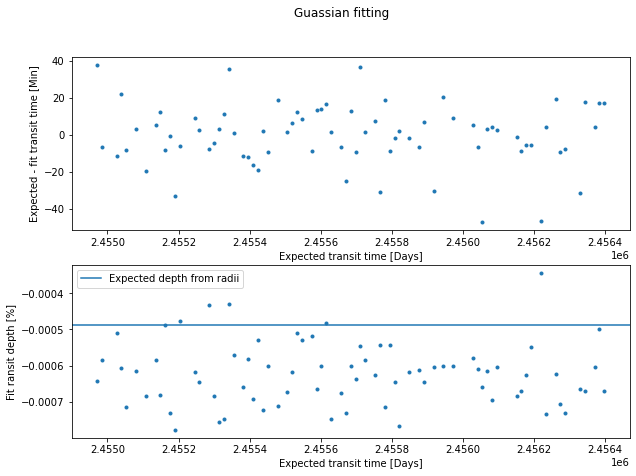

In [89]:
# make O-C plots (expected - observed transit times as a functions of expected)

plt.figure(figsize = [10,7])
plt.subplot(211)
plt.plot(expected_midpoints, delta_midpoints * 1440, '.')
plt.xlabel('Expected transit time [Days]'); plt.ylabel('Expected - fit transit time [Min]')

plt.subplot(212)
plt.plot(expected_midpoints, depths, '.')
plt.axhline(expected_depth, label = 'Expected depth from radii')
plt.xlabel('Expected transit time [Days]'); plt.ylabel('Fit ransit depth [%]')
plt.legend()

plt.suptitle('Guassian fitting')

## Fit transits with ktransit
#### Modified from tutorial at https://github.com/mrtommyb/ktransit

In [484]:
!pip install ktransit

Defaulting to user installation because normal site-packages is not writeable


In [37]:
import ktransit
from ktransit import FitTransit

Best-fitting stellar parameters

Best-fitting planet parameters for planet 0
T0: 2454970.84083
rprs: 0.022094768253968253



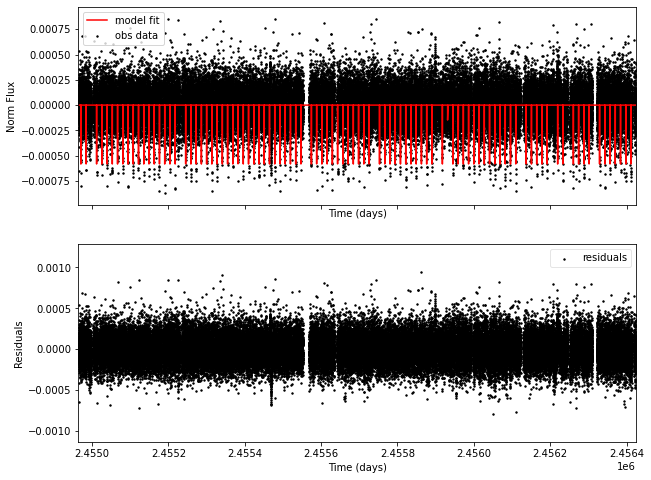

In [45]:
# fit the entire lightcurve

fitT = FitTransit()
fitT.add_guess_star()    
fitT.add_guess_planet(period=period, impact=impact_parameter, T0=t0, rprs=RpRs)
fitT.add_data(time=time, flux=flux -1, ferr=err)

vary_star = []                     # free stellar parameters
vary_planet = (['T0',  'rprs'])    # free planetary parameters

fitT.free_parameters(vary_star, vary_planet)
fitT.do_fit()                      # run the fitting

fitT.print_results()               # print some results

fig = ktransit.plot_results(time,flux-1,fitT.transitmodel) 
fig.show()

In [85]:
# fit one transit

def fit_ktransit(transit_idx, to_plot, verbosity):
    skip = 0
    
    # area around expected transit
    low_bound = t0 + period * transit_idx - period/4     # /4 is somewhat arbitrary
    up_bound = t0 + period * transit_idx + period/4
    interval = (low_bound < time)*(time < up_bound)
    length = len(time[interval])
    
    # for checking that datapoints immediatley around transit is not missing
    # becuase the location of the missing data within the transit window mattters
    inner_low_bound = t0 + period * transit_idx - period/8     # /4 is somewhat arbitrary
    inner_up_bound = t0 + period * transit_idx + period/8
    # all intervals are ~same in time duration, but not in number of steps/pixels
    inner_interval = (inner_low_bound < time)*(time < inner_up_bound)
    inner_time_interval = np.max(time[time < inner_up_bound]) -  np.min(time[time > inner_low_bound])
    inner_length = len(time[inner_interval])
    
    if verbosity == 2:
    #    print(low_bound); print(up_bound)
    #    print(np.min(time[time > low_bound])); print(np.max(time[time < up_bound]))
    #    print(time_interval)
    #    plt.plot(time[interval],flux[interval], '.', markersize = 5,label = 'Kepler-69b Data')
         print(length)
    apply_thresholds = 1
    min_points_threshold = expected_points_per_window * 0.90
    if apply_thresholds:
        #if time_interval < period/4: # the last interval won't necessarily contain a full transit and some contain missing data; threshold somewhat arbitrary
        #    print('Could not model transit ' + str(transit_idx) + ' (interval too short, likely due to missing data).')          
        #    return [np.nan, np.nan, np.nan], np.nan, np.nan, np.nan, np.nan
        #if (length < 250) or (inner_length < 150): # these thresholds might be too harsh
        #    print('Could not model transit ' + str(transit_idx) + ' (due to missing data).')          
        #    return [np.nan, np.nan, np.nan], np.nan, np.nan, np.nan, np.nan
        #if (inner_length < 150): # these thresholds might be too harsh
        #    print('Could not model transit ' + str(transit_idx) + ' (due to missing data).')          
        #    return np.nan, np.nan, np.nan, np.nan, np.nan, np.nan
        if (length < min_points_threshold):
            print('Could not model transit ' + str(transit_idx) + ' (due to missing data).')  
            print()
            skip = 1
            return [np.nan, np.nan, np.nan], np.nan, np.nan, np.nan, np.nan, skip
    
    print('Modelling transit ' + str(transit_idx))

    fitT = FitTransit()
    fitT.add_guess_star()    
    fitT.add_guess_planet(period=period, impact=impact_parameter, T0=t0 + transit_idx*period, rprs=RpRs)
    fitT.add_data(time=time[interval], flux=flux[interval] - 1, ferr=err[interval])

    vary_star = []                     # free stellar parameters
    vary_planet = (['T0',  'rprs'])    # free planetary parameters

    fitT.free_parameters(vary_star, vary_planet)
    fitT.do_fit()                      # run the fitting
    fit_t0 = fitT.fitresultplanets['pnum0']['T0']
    fit_rprs = fitT.fitresultplanets['pnum0']['rprs']
    
    #fitT.print_results()               # print some results
    RMSE = np.sqrt(np.sum(((flux[interval] - 1) - fitT.transitmodel)**2/length))
    print('t0 = ' + str(np.round(fit_t0,4)))
    print('rprs = ' + str(np.round(fit_rprs,4)))
    print('RMSE = ' + str(np.round(RMSE,4)))
    print()
    
    if to_plot:
        #fig = ktransit.plot_results(time[(low_bound < time)*(time < up_bound)],flux[(low_bound < time)*(time < up_bound)]-1,fitT.transitmodel) 
        #plt.title('Kepler-69 b, transit ' + str(transit_idx))
        #fig.show()
        plt.figure(figsize = [12,6])
        plt.plot(time[interval],flux[interval] - 1 , '.', markersize = 5,label = 'Kepler-69b Data')
        plt.plot(time[interval], fitT.transitmodel, label = 'ktransit fit')
        plt.legend()
        plt.xlabel('Time [BKJD Days]')
        plt.ylabel('Flux [Relative Units]')
        plt.title('Kepler-69 b, transit ' + str(transit_idx))
        
        #fig = ktransit.plot_results(time[interval],flux[interval],fitT.transitmodel)
        #fig.show()
    
    return fit_t0, fit_rprs, RMSE, length, inner_length, time_interval, skip
    
#fit_ktransit(0,1)
#fit_ktransit(10,1)
#fit_ktransit(100,1)

num_transits = int(np.floor((time[-1] - t0) / period))
expected_midpoints = np.arange(t0, t0 + (num_transits) * period, period)
fit_t0_arr = [] # store midpoints of all transits
depths = [] # store transit depths
lengths = [] # store number of points in each transit interval window
inner_lengths = [] # store number of points in transit window near transit
time_intervals = [] # store time intervals of each transit window
RMSE_arr = [] # store RMSE of the fit to each transit
skipped = [] # record which transit idxs are skipped
fit_t0_arr = [] # record transit midpoint (?) values from the fit
fit_rprs_arr = [] # record planet to star radius ratio from the fit
for transit_idx in np.linspace(0,num_transits-1,num_transits):
    try: 
        fit_t0, fit_rprs, RMSE, length, inner_length, time_interval, skip = fit_ktransit(transit_idx, to_plot = 0, verbosity = 0)
    except ValueError:
        print('skipped transit ' + str(transit_idx))
        print()
        skip = 1
        fit_t0, fit_rprs, RMSE, length, inner_length, time_interval, skip = np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, skip
    fit_t0_arr += [fit_t0]
    fit_rprs_arr += [fit_rprs]
    lengths += [length]
    inner_lengths += [inner_length]
    RMSE_arr += [RMSE]
    time_intervals += [time_interval]
    if skip:
        skipped += [transit_idx]
transit_depth_arr = np.array(fit_rprs_arr)**2 # is this correct?       
mean_transit_depth = np.nanmean(transit_depth_arr)
delta_depths = mean_transit_depth - transit_depth_arr
delta_midpoints = expected_midpoints - fit_t0_arr # is this correct? 

print()
print(str(len(skipped)) + ' transits skipped out of ' + str(num_transits) + ' total transits.')

Modelling transit 0.0
t0 = 2454970.8408
rprs = 0.0221
RMSE = 0.0002

Modelling transit 1.0
t0 = 2454984.5632
rprs = 0.0221
RMSE = 0.0002

Could not model transit 2.0 (due to missing data).

skipped transit 2.0

Could not model transit 3.0 (due to missing data).

skipped transit 3.0

Modelling transit 4.0
t0 = 2455025.7399
rprs = 0.0215
RMSE = 0.0002

Modelling transit 5.0
t0 = 2455039.4479
rprs = 0.0224
RMSE = 0.0001

Modelling transit 6.0
t0 = 2455053.175
rprs = 0.0221
RMSE = 0.0002

Could not model transit 7.0 (due to missing data).

skipped transit 7.0

Modelling transit 8.0
t0 = 2455080.6198
rprs = 0.0221
RMSE = 0.0002

Could not model transit 9.0 (due to missing data).

skipped transit 9.0

Modelling transit 10.0
t0 = 2455108.0829
rprs = 0.0234
RMSE = 0.0001

Could not model transit 11.0 (due to missing data).

skipped transit 11.0

Modelling transit 12.0
t0 = 2455135.5268
rprs = 0.022
RMSE = 0.0001

Modelling transit 13.0
t0 = 2455149.2316
rprs = 0.0221
RMSE = 0.0002

Modelling t

Text(0, 0.5, 'Midpoint - expected midpoint')

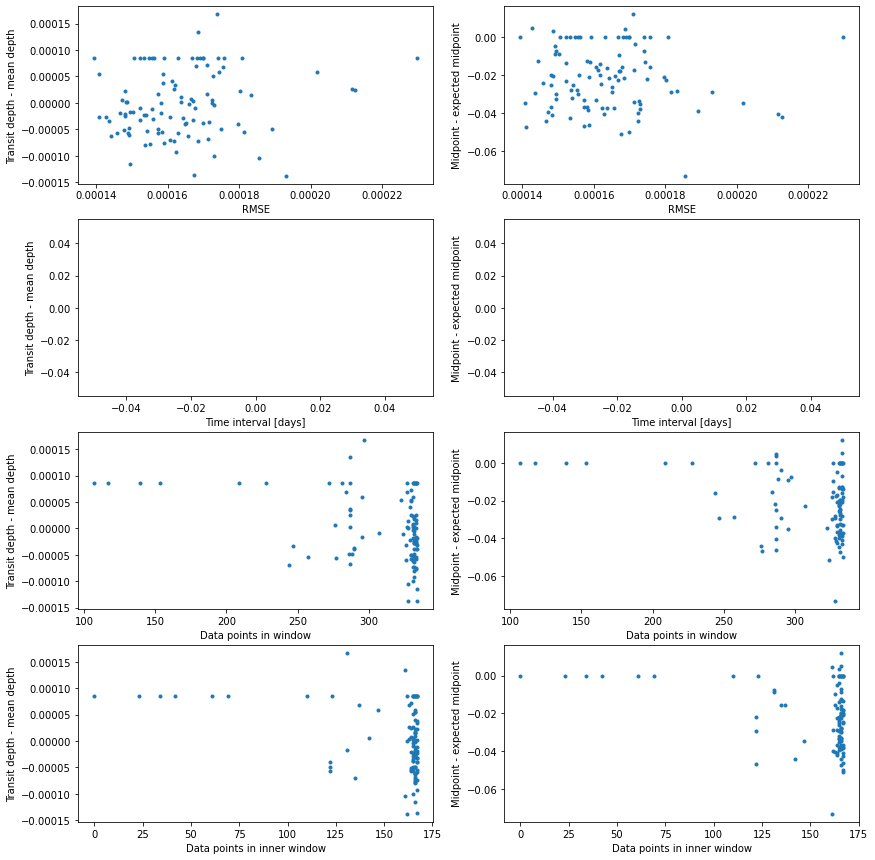

In [515]:
# Determine quality thresholds on goodness of fit and amount of data in each fit

# RMSE threshold
plt.figure(figsize = [14,15])
plt.subplot(421)
plt.plot(RMSE_arr, delta_depths,'.')
#plt.yscale('symlog')
plt.xlabel('RMSE'); plt.ylabel('Transit depth - mean depth')
plt.subplot(422)
plt.plot(RMSE_arr, delta_midpoints,'.')
#plt.yscale('symlog')
plt.xlabel('RMSE'); plt.ylabel('Midpoint - expected midpoint')

# transit window time interval threshold
#plt.figure(figsize = [14,5])
plt.subplot(423)
plt.plot(time_intervals, delta_depths,'.')
#plt.yscale('symlog')
plt.xlabel('Time interval [days]'); plt.ylabel('Transit depth - mean depth')
plt.subplot(424)
plt.plot(time_intervals, delta_midpoints,'.')
#plt.yscale('symlog')
plt.xlabel('Time interval [days]'); plt.ylabel('Midpoint - expected midpoint')

# transit window number of data points threshold
#plt.figure(figsize = [14,5])
plt.subplot(425)
plt.plot(lengths, delta_depths,'.')
plt.xlabel('Data points in window'); plt.ylabel('Transit depth - mean depth')
plt.subplot(426)
plt.plot(lengths, delta_midpoints,'.')
plt.xlabel('Data points in window'); plt.ylabel('Midpoint - expected midpoint')

# inner transit window (ie. closer to transit) number of data points threshold
#plt.figure(figsize = [14,5])
plt.subplot(427)
plt.plot(inner_lengths, delta_depths,'.')
plt.xlabel('Data points in inner window'); plt.ylabel('Transit depth - mean depth')
plt.subplot(428)
plt.plot(inner_lengths, delta_midpoints,'.')
plt.xlabel('Data points in inner window'); plt.ylabel('Midpoint - expected midpoint')


Text(0.5, 0.98, 'ktransit fitting')

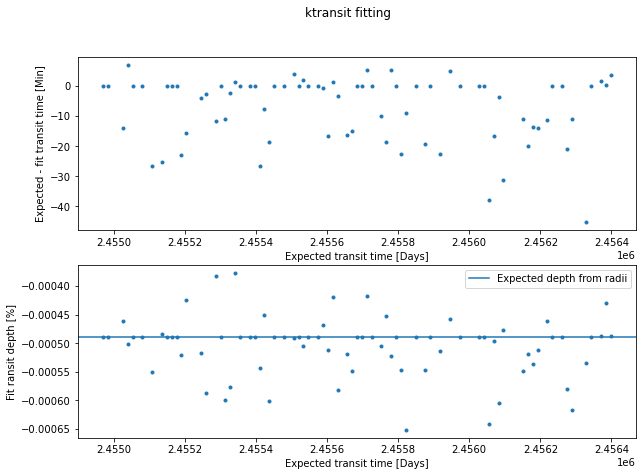

In [86]:
# make O-C plots (expected - observed transit times as a functions of expected)

plt.figure(figsize = [10,7])
plt.subplot(211)
plt.plot(expected_midpoints, delta_midpoints * 1440, '.')
plt.xlabel('Expected transit time [Days]'); plt.ylabel('Expected - fit transit time [Min]')

plt.subplot(212)
plt.plot(expected_midpoints, -transit_depth_arr, '.')
plt.axhline(expected_depth, label = 'Expected depth from radii')
plt.xlabel('Expected transit time [Days]'); plt.ylabel('Fit ransit depth [%]')
plt.legend()

plt.suptitle('ktransit fitting')

# CODE SNIPPETS FOR TESTING BELOW HERE

(2456296.874, 2456334.318)

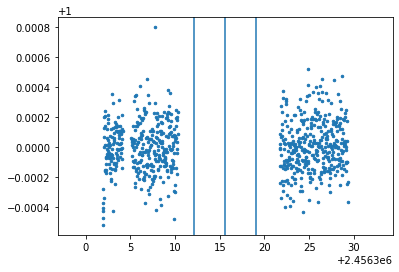

In [304]:
transit_idx = 9
low_bound = t0 + period * transit_idx - period    # /4 is somewhat arbitrary
up_bound = t0 + period * transit_idx + period
interval = (low_bound < time)*(time < up_bound)
plt.plot(time[interval],flux[interval], '.', markersize = 5,label = 'Kepler-69b Data')
plt.axvline(t0 + period * transit_idx - period/4)
plt.axvline(t0 + period * transit_idx + period/4)
plt.axvline(t0+period * transit_idx)
plt.xlim([low_bound-5, up_bound + 5])

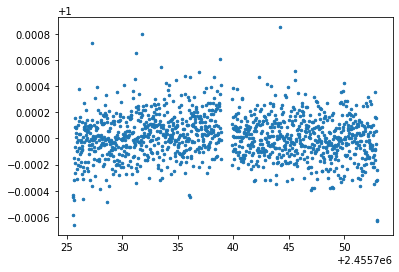

In [471]:
transit_idx = 56
low_bound = t0 + period * transit_idx - period     # /4 is somewhat arbitrary
up_bound = t0 + period * transit_idx + period
# all intervals are ~same in time duration, but not in number of steps/pixels
interval = (low_bound < time)*(time < up_bound)
time_interval = np.max(time[time < up_bound]) -  np.min(time[time > low_bound])
plt.plot(time[interval],flux[interval], '.', markersize = 5,label = 'Kepler-69b Data')